In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import mygene
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gseapy as gp


## 1. RNA-seq Dataset Exploration

In [16]:
df = pd.read_csv('../data/processed/SRP053101/SRP053101.tsv', sep='\t')
df.head()

,Gene,SRR1785238,SRR1785239,SRR1785240,SRR1785241,SRR1785242,SRR1785243,SRR1785244,SRR1785245,SRR1785246,...,SRR1785316,SRR1785317,SRR1785318,SRR1785319,SRR1785320,SRR1785321,SRR1785322,SRR1785323,SRR1785324,SRR1785325
0,ENSG00000000003,6.328873,6.213042,6.566083,7.431347,6.577885,6.622472,6.061065,6.185052,7.083283,...,8.095718,6.850729,6.190149,6.075060,7.108820,7.030187,6.749068,6.897820,5.484898,6.410261
1,ENSG00000000005,13.173146,12.876556,10.828189,12.335142,22.767086,21.927400,3.438301,3.365119,17.128099,...,5.218452,5.011540,6.540894,6.347032,10.704100,10.328805,8.199832,8.299783,6.647849,7.419524
2,ENSG00000000419,3.370290,3.527564,3.562937,3.661824,3.778322,3.697747,3.223593,3.277145,3.827415,...,3.806907,3.529330,3.979054,3.727725,3.708256,3.773404,3.664229,3.690338,3.119168,3.709236
3,ENSG00000000457,2.688080,2.836431,2.768769,2.896969,3.017560,2.767193,2.720313,2.659437,2.979878,...,3.012767,2.948514,2.715955,2.786659,2.895226,2.940234,2.679154,2.648348,2.539504,2.634708
4,ENSG00000000460,1.905655,1.892335,1.957807,1.944157,2.021323,1.936682,1.602395,1.960482,2.087508,...,1.701300,1.867803,1.954910,1.899056,1.906454,1.766193,2.056871,2.008651,2.034759,1.844021


In [17]:
df.shape

(43355, 89)

In [18]:
#convert ensembl IDS to gene names

mg = mygene.MyGeneInfo()

results = mg.querymany(df['Gene'].tolist(), 
                      scopes='ensembl.gene', 
                      fields='symbol', 
                      species='human')

id_to_symbol = {}
for item in results:
    ensembl_id = item['query']
    symbol = item.get('symbol', ensembl_id)  # Use original ID if no symbol found
    id_to_symbol[ensembl_id] = symbol

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
26 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000188660', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('E
1370 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000131484', 'ENS
26 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000188660', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('E
1370 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000131484', 'ENS


In [ ]:


df.insert(0, 'Gene_Symbol', df['Gene'].map(id_to_symbol))
print(f"Successfully converted: {(df['Gene_Symbol'] != df['Gene']).sum()} genes")
df[['Gene', 'Gene_Symbol']].head(10)


Successfully converted: 33343 genes


,Gene,Gene_Symbol
0,ENSG00000000003,TSPAN6
1,ENSG00000000005,TNMD
2,ENSG00000000419,DPM1
3,ENSG00000000457,SCYL3
4,ENSG00000000460,FIRRM
5,ENSG00000000938,FGR
6,ENSG00000000971,CFH
7,ENSG00000001036,FUCA2
8,ENSG00000001084,GCLC
9,ENSG00000001167,NFYA


In [20]:
df.head

<bound method NDFrame.head of            Gene_Symbol             Gene  SRR1785238  SRR1785239  SRR1785240  \
0               TSPAN6  ENSG00000000003    6.328873    6.213042    6.566083   
1                 TNMD  ENSG00000000005   13.173146   12.876556   10.828189   
2                 DPM1  ENSG00000000419    3.370290    3.527564    3.562937   
3                SCYL3  ENSG00000000457    2.688080    2.836431    2.768769   
4                FIRRM  ENSG00000000460    1.905655    1.892335    1.957807   
...                ...              ...         ...         ...         ...   
43350  ENSG00000285498  ENSG00000285498    0.060086    0.058939    0.062073   
43351  ENSG00000285505  ENSG00000285505    0.060086    0.704677    0.431207   
43352     LOC128706666  ENSG00000285508    1.886209    1.693996    2.032619   
43353      TBCEL-TECTA  ENSG00000285509    0.696041    1.053210    0.764423   
43354  ENSG00000285513  ENSG00000285513    0.060086    0.058939    0.062073   

       SRR1785241  SR

In [21]:
# Log-scale the data and calculate per-gene median expression ranges


# Get expression data (all columns except Gene and Gene_Symbol)

expression_data = df.iloc[:, 2:]
log_expression = np.log2(expression_data + 1)

median_expression = log_expression.median(axis=1)

In [25]:
median_expression.describe()
median_expression.head()

0    2.971477
1    3.534770
2    2.217926
3    1.928977
4    1.556601
dtype: float64

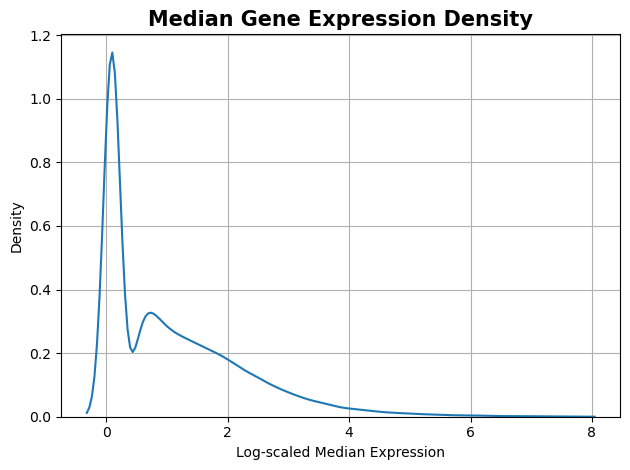

In [27]:
# 1. Density plot of log-scaled median expression
sns.kdeplot(median_expression, label='Median Gene Expression Density')
plt.title('Median Gene Expression Density', fontweight='bold', fontsize=15)
plt.xlabel('Log-scaled Median Expression')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.savefig('../results/figures/median_expression_density.png')
plt.show()

## 2. Principal Component Analysis

In [29]:
# Group samples using metadata 
metadata = pd.read_csv('../data/processed/SRP053101/metadata_SRP053101.tsv', sep='\t')
metadata.head()
metadata.set_index('refinebio_accession_code', inplace=True)
df = df[metadata.index]

#Group 0 is before treatment and Group 3 is after treatment

metadata['time_group'] = np.where(metadata['refinebio_title'].str.endswith('T0'), 0,
                                  np.where(metadata['refinebio_title'].str.endswith('T3'), 
                                           3, np.nan))
metadata[['time_group', 'refinebio_title']]

,time_group,refinebio_title
refinebio_accession_code,,
SRR1785238,0.0,SAT01_T0
SRR1785239,0.0,SAT01_T0
SRR1785240,0.0,SAT02_T0
SRR1785241,0.0,SAT02_T0
SRR1785242,0.0,SAT03_T0
...,...,...
SRR1785321,3.0,SAT20_T3
SRR1785322,3.0,SAT21_T3
SRR1785323,3.0,SAT21_T3


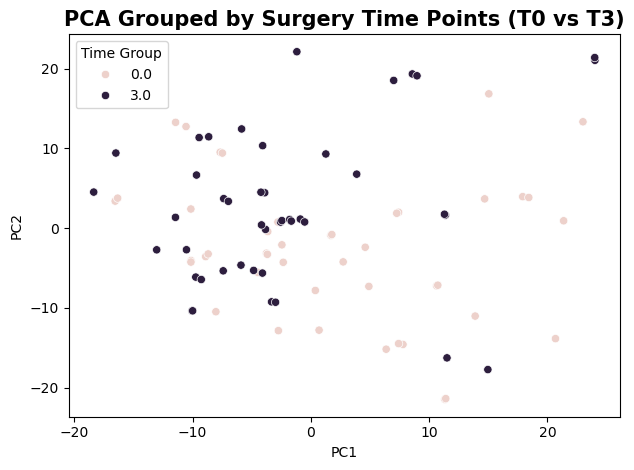

In [34]:
# run PCA on log-expression data
pca = PCA(n_components=2)
pc = pca.fit_transform(log_expression.T)

pc_df = pd.DataFrame(data=pc, columns=['PC1', 'PC2'], index=metadata.index)
pc_df = pc_df.join(metadata[['time_group']])
pc_df.head

sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='time_group')
plt.title('PCA Grouped by Surgery Time Points (T0 vs T3)', fontweight='bold', fontsize=15)
plt.legend(title='Time Group')
plt.tight_layout()
plt.savefig('../results/figures/pca.png')
plt.show()

In [29]:
pc_df.shape

(88, 3)

## 3. Differential Expression Analysis

## 4. Gene Set Enrichment Analysis

In [4]:
significant_genes = pd.read_csv('../results/significant_genes_T3_vs_T0.csv')
significant_genes.head

<bound method NDFrame.head of                 gene gene_symbol   baseMean  log2FoldChange     lfcSE  \
0    ENSG00000164128       NPY1R  22.387592       -0.524289  0.080306   
1    ENSG00000145423       SFRP2   9.954843       -1.091122  0.170615   
2    ENSG00000116133      DHCR24  14.864567       -0.609263  0.099876   
3    ENSG00000113083         LOX  11.262108       -0.599049  0.097483   
4    ENSG00000174697         LEP  91.846900       -0.310507  0.052519   
..               ...         ...        ...             ...       ...   
220  ENSG00000008988       RPS20  69.505135        0.078402  0.040548   
221  ENSG00000079337     RAPGEF3  26.023732        0.139759  0.090755   
222  ENSG00000110700       RPS13  29.502307        0.108734  0.063978   
223  ENSG00000124225      PMEPA1  30.410728       -0.129074  0.083128   
224  ENSG00000151414        NEK7  17.546422       -0.134044  0.088084   

         stat        pvalue          padj  significant  
0   -6.909569  4.861287e-12  1.05392

In [35]:
significant_gene_symbols = significant_genes['gene_symbol'].dropna()
print(significant_gene_symbols.shape)
enrichment = gp.enrichr(gene_list=significant_gene_symbols.tolist(),
                        gene_sets='GO_Biological_Process_2023',
                        organism='Human',
                        )

sorted_res = enrichment.res2d.sort_values(by='Adjusted P-value', ascending=True)
sorted_res.to_csv('../results/enrichment_gseapy_gene_ontology.csv')


(225,)
